In [1]:
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
random.seed(2147483647)
random.shuffle(words)
n = len(words)

n_train = int(0.8 * n)
n_dev = int(0.1 * n)

words_train = words[:n_train]
words_dev = words[n_train:n_train + n_dev]
words_test = words[n_train + n_dev:]

chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(stoi)

In [3]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / (fan_in ** 0.5)
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True, unbiased=False)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        if self.training:
            with torch.no_grad():
                self.running_mean = self.running_mean * (1 - self.momentum) + xmean * self.momentum
                self.running_var = self.running_var * (1 - self.momentum) + xvar * self.momentum
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

In [4]:
def build_xy(words, stoi, block_size=3):
    x, y = [], []
    for w in words[:]:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            x.append(context)
            y.append(ix)
            context = context[1:] + [ix]
    X, Y = torch.tensor(x), torch.tensor(y)
    return X, Y

def data_nll(X, Y, C):
    for layer in layers:
        if isinstance(layer, BatchNorm1d):
            layer.training = False
    emb = C[X]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    logits = x
    loss = F.cross_entropy(logits, Y)
    return loss.item()

def generate(C, itos, block_size=3, seed=2147483647, num_samples=5):
    for layer in layers:
        if isinstance(layer, BatchNorm1d):
            layer.training = False

    g = torch.Generator().manual_seed(seed)
    for i in range(num_samples):
        out = []
        context = [0] * block_size
        while True:
            ctx = torch.tensor(context)
            emb = C[ctx]
            x = emb.view(1, -1)
            for layer in layers:
                x = layer(x)
            logits = x
            p = logits.squeeze(0).softmax(dim=0)
            ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
            context = context[1:] + [ix]
            if ix == 0:
                break
            else:
                out.append(ix)
        print(''.join(itos[i] for i in out))

In [5]:
Xtr, Ytr = build_xy(words_train, stoi)
Xdev, Ydev = build_xy(words_dev, stoi)
Xte, Yte = build_xy(words_test, stoi)

n_emb = 10
n_hidden = 100
block_size = 3

In [6]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_emb), generator=g)
layers = [
    Linear(n_emb * block_size, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size),
]


layers[-1].gamma *= 0.1
#layers[-1].weight *= 0.1
for layer in layers[:-1]:
    if isinstance(layer, Linear):
        layer.weight *= 1 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

47351


In [7]:
g = torch.Generator().manual_seed(2147483647)
steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 1 if i < 100000 else 0.1 if i < 1000000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    if i % 10000 == 0:
        print(f'{i:7d}/{steps:7d}: {loss.item():.4f}')
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])

    lossi.append(loss.item())

      0/ 200000: 3.2978
  10000/ 200000: 2.3018
  20000/ 200000: 1.9715
  30000/ 200000: 2.1516
  40000/ 200000: 2.4524
  50000/ 200000: 2.3546
  60000/ 200000: 2.0807
  70000/ 200000: 1.7707
  80000/ 200000: 2.0815
  90000/ 200000: 2.3520
 100000/ 200000: 2.1135
 110000/ 200000: 2.4744
 120000/ 200000: 1.8172
 130000/ 200000: 2.1011
 140000/ 200000: 1.7151
 150000/ 200000: 2.3934
 160000/ 200000: 2.4272
 170000/ 200000: 2.1872
 180000/ 200000: 1.8941
 190000/ 200000: 1.8483


layer 1 (      Tanh): mean -0.08, std 0.98, saturated 94.59%
layer 4 (      Tanh): mean +0.01, std 0.82, saturated 35.91%
layer 7 (      Tanh): mean -0.02, std 0.84, saturated 39.78%
layer 10 (      Tanh): mean +0.04, std 0.84, saturated 39.12%
layer 13 (      Tanh): mean +0.01, std 0.84, saturated 39.19%


Text(0.5, 1.0, 'activation distribution')

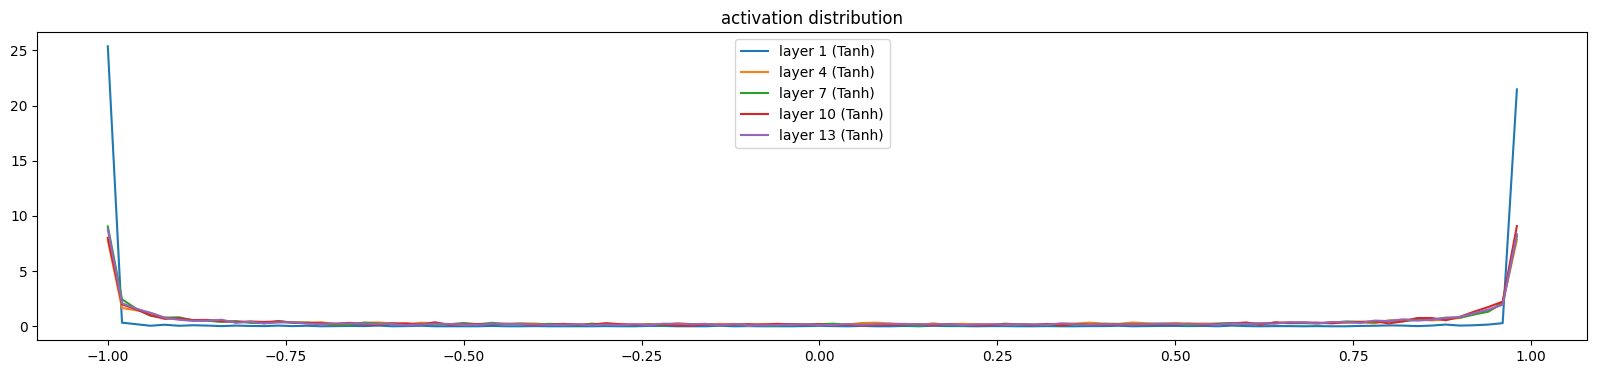

In [9]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean() * 100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('activation distribution')

layer 1 (      Tanh): mean +0.000000, std +0.002228
layer 4 (      Tanh): mean +0.000000, std +0.001869
layer 7 (      Tanh): mean -0.000000, std +0.001785
layer 10 (      Tanh): mean -0.000000, std +0.001975
layer 13 (      Tanh): mean +0.000000, std +0.003575


Text(0.5, 1.0, 'activation distribution')

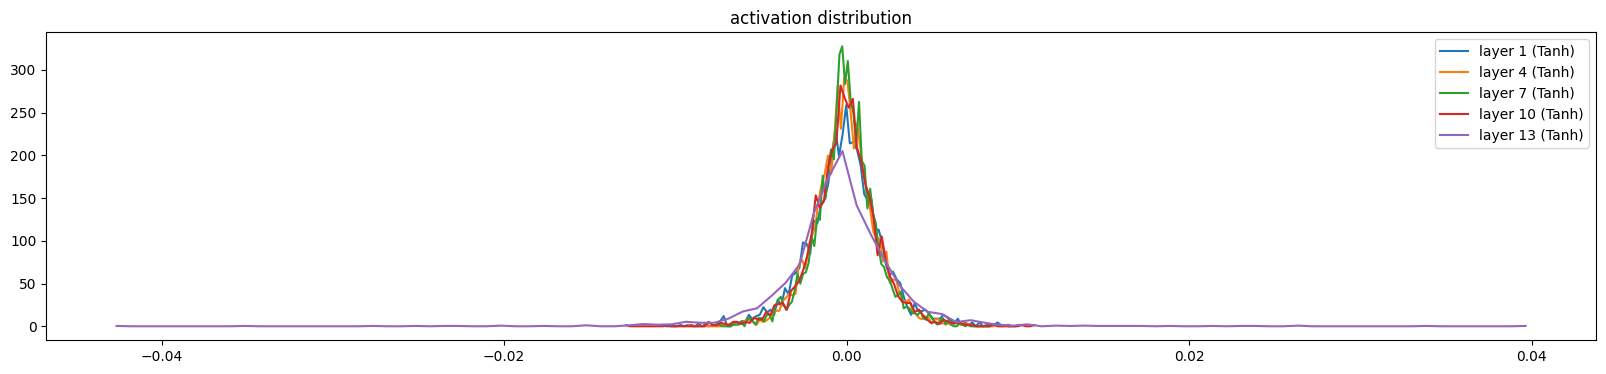

In [10]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %+f' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('activation distribution')

weight   (27, 10) | mean +0.000228 | std +0.005804 | grad:data ratio 2.373965e-03
weight  (30, 100) | mean +0.000100 | std +0.003383 | grad:data ratio 2.451452e-03
weight (100, 100) | mean +0.000001 | std +0.001405 | grad:data ratio 2.243100e-03
weight (100, 100) | mean +0.000012 | std +0.001257 | grad:data ratio 2.452815e-03
weight (100, 100) | mean +0.000007 | std +0.001322 | grad:data ratio 2.824085e-03
weight (100, 100) | mean -0.000022 | std +0.001352 | grad:data ratio 2.855886e-03
weight  (100, 27) | mean +0.000018 | std +0.002389 | grad:data ratio 2.565538e-03


Text(0.5, 1.0, 'weights gradient distribution')

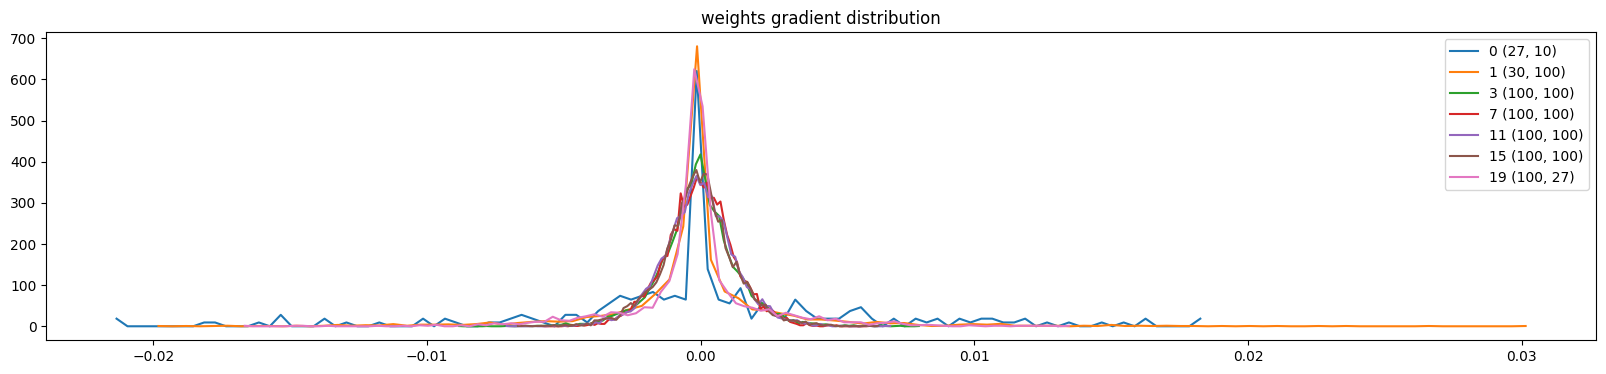

In [11]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %+f | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution')

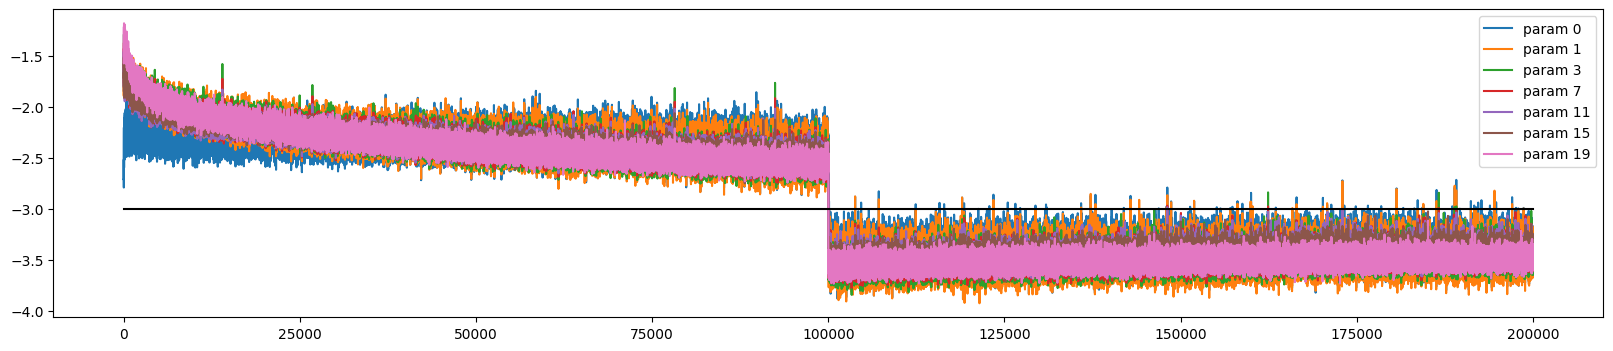

In [12]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k')
plt.legend(legends)

In [13]:
print(data_nll(Xtr, Ytr, C))
print(data_nll(Xdev, Ydev, C))
print(data_nll(Xte, Yte, C))

2.0141994953155518
2.1002490520477295
2.0877509117126465


In [14]:
generate(C, itos)

dex
maleah
makilah
tyha
kalimitta
